In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc,os
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
TOKENIZER_PATH = "llama_odia_tokenizer"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2095.841064453125


## Extend the size of embedding

In [2]:
print(f'embedding size before extension:{model.model.embed_tokens}')
print(f'LM head size before extension:{model.lm_head}')

# Resize the model's token embeddings to match the tokenizer's vocab size
model.resize_token_embeddings(len(tokenizer))

print(f'embedding size after extension:{model.model.embed_tokens}')
print(f'LM head size after extension:{model.lm_head}')

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


embedding size before extension:Embedding(128256, 3072)
LM head size before extension:Linear(in_features=3072, out_features=128256, bias=False)
embedding size after extension:Embedding(131142, 3072)
LM head size after extension:Linear(in_features=3072, out_features=131142, bias=False)


# Load a Multi Lingual Dataset

In [3]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

In [4]:
dataset['train'][50]

{'instruction': 'ଓଡ଼ିଶାର ଉଦୟଗିରି ଏବଂ ଖଣ୍ଡଗିରି ଗୁମ୍ଫାର ଇତିହାସ କ’ଣ?',
 'input': '',
 'output': 'ଉଦୟଗିରି ଏବଂ ଖଣ୍ଡଗିରି ଗୁମ୍ଫା ଭାରତର ଓଡ଼ିଶା ରାଜ୍ୟରେ ଅବସ୍ଥିତ ପ୍ରାଚୀନ ଗୁମ୍ଫା ପରିସରର ଏକ ସମୂହ। ଏହି ଗୁମ୍ଫା ଗୁଡିକ ଖ୍ରୀଷ୍ଟପୂର୍ବ ଦ୍ୱିତୀୟ ଶତାବ୍ଦୀ ଏବଂ ପ୍ରଥମ ଶତାବ୍ଦୀ ମଧ୍ୟରେ ଜୈନ ସନ୍ନ୍ୟାସୀମାନଙ୍କ ଦ୍ୱାରା ବାଲୁକା ପଥରରେ ଖୋଦିତ ହୋଇଥିବା ଜଣାଯାଏ।\nଉଦୟଗିରି ଗୁମ୍ଫା ଗୁଡିକ ବୃହତ ଏବଂ ଅଧିକ ଜଟିଳ ହୋଇଥିବାବେଳେ ଖଣ୍ଡଗିରି ଗୁମ୍ଫା ଗୁଡିକ ଛୋଟ ଏବଂ ଡିଜାଇନ ଦୃଷ୍ଟିରୁ ସରଳ। ଏହି ପ୍ରାଚୀନ ଗୁମ୍ଫା ଗୁଡିକ ପ୍ରାଚୀନ ଭାରତୀୟ ସଭ୍ୟତାର ସ୍ଥାପତ୍ୟ କୌଶଳ ଏବଂ କଳାତ୍ମକ ଶ୍ରେଷ୍ଠତାର ପ୍ରମାଣ।\nବିଗତ ବର୍ଷମାନଙ୍କରେ ଏହି ଗୁମ୍ଫା ସାରା ବିଶ୍ୱରୁ ପର୍ଯ୍ୟଟକଙ୍କ ଆକର୍ଷଣ କେନ୍ଦ୍ର ପାଲଟିଛି ଏବଂ ଭାରତୀୟ ପ୍ରତ୍ନତାତ୍ୱିକ ସର୍ବେକ୍ଷଣ ଦ୍ୱାରା ସଂରକ୍ଷିତ ହୋଇଛି। ଭାରତର ସମୃଦ୍ଧ ସାଂସ୍କୃତିକ ଐତିହ୍ୟ ପ୍ରତି ଆଗ୍ରହୀ ଯେକୌଣସି ବ୍ୟକ୍ତି ଏହି ଗୁମ୍ଫାକୁ ଦେଖିବା ଉଚିତ।'}

total number of tokens used during training:694439


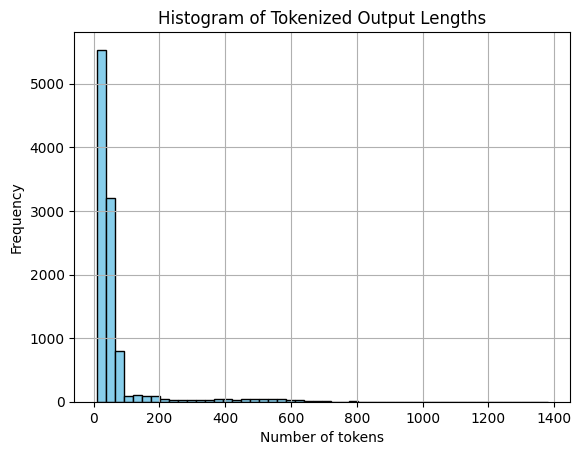

In [5]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['output'])['input_ids']) for example in dataset['train']]
print(f'total number of tokens used during training:{sum(lengths)}')
# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Create the Dataset Object for Pytorch-Dataset

In [6]:
# Custom PyTorch Dataset
class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
        full_text = prompt+f'''{answer}<|eot_id|>'''

        tokenized = tokenizer(full_text, truncation=True, add_special_tokens=False, padding="max_length", max_length=300)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [7]:
train_dataset = LlamaDataset(dataset['train'])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [8]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.v_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.o_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.gate_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.up_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.down_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.input_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.post_attention_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.1.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.v_proj.weight  dt

# Purpose of `prepare_model_for_kbit_training`

When you load a model in 4-bit or 8-bit precision using bitsandbytes, some layers (like LayerNorm) still remain in full precision (float32), and certain operations (like weight updates) can be unstable or incompatible if done blindly on quantized weights.

- Casts `LayerNorm` layers to `float32`
- Sets `requires_grad=False` for all model parameters
- Wraps the output layer (like `lm_head`) in `float32`

In [9]:
model = prepare_model_for_kbit_training(model)

In [10]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.float32  requirs grad:  False
model.layers.0.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.v_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.o_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.gate_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.up_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.down_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.input_layernorm.weight  dtype: torch.float32  requirs grad:  False
model.layers.0.post_attention_layernorm.weight  dtype: torch.float32  requirs grad:  False
model.layers.1.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.v_proj.weight 

In [11]:
config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 97,255,424 || all params: 3,318,871,040 || trainable%: 2.9304


In [12]:
model.lm_head.weight.requires_grad = True
model.model.model.embed_tokens.weight.requires_grad = True

In [13]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.

# Finetune the LLAMA model on a single text

In [14]:
for batch in train_dataloader:
    break

tokenizer.batch_decode(batch['input_ids'])

["<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\nବାହ୍ୟ ଝିଲ୍ଲିର ପିଞ୍ଚ ଅଫ ଭାଗରେ କ 'ଣ ହୁଏ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n, ପେରିପ୍ଲାଜମିକ ସାମଗ୍ରୀକୁ ଆବଦ୍ଧ କରି ଲିପିଡ ବାଇଲେୟରରୁ ନିର୍ମିତ ଗୋଲାକାର ଗଠନ।<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id

In [15]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to(device)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=256,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=256,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [16]:
dataset['train'][40]

{'instruction': 'ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?',
 'input': '',
 'output': 'ଏକାଦଶ ଶତାବ୍ଦୀରେ ନିର୍ମାଣ କରାଯାଇଥିବା ରାଜାରାଣୀ ମନ୍ଦିର ଭୁବନେଶ୍ୱର ସହରର ଏକ ଲୋକପ୍ରିୟ ପର୍ଯ୍ୟଟନସ୍ଥଳୀ।\nଏକାଦଶ ଶତାବ୍ଦୀରେ ଏହି ଅଂଚଳରେ ରାଜାରାଣୀ ରାଜବଂଶ ଶାସନ କରିଥିଲେ। ବିଶ୍ୱାସ କରାଯାଏ ଯେ ଏହି ମନ୍ଦିର ପ୍ରଥମେ ଭଗବାନ ଶିବଙ୍କୁ ସମର୍ପିତ ଥିଲା, କିନ୍ତୁ ପରେ ଏହା ଭଗବାନ ବିଷ୍ଣୁଙ୍କ ମନ୍ଦିର ପାଲଟିଥିଲା।\nରାଜାରାଣୀ ମନ୍ଦିରର ସ୍ଥାପତ୍ୟ ଅଦ୍ୱିତୀୟ, କାରଣ ଏଠାରେ କୌଣସି ପବିତ୍ର ସ୍ଥାନ କିମ୍ବା କେନ୍ଦ୍ରୀୟ ମନ୍ଦିର ନାହିଁ, ଯାହାକି ହିନ୍ଦୁ ମନ୍ଦିରର ଏକ ବିଶେଷ ବୈଶିଷ୍ଟ୍ୟ, ଏହା ପରିବର୍ତ୍ତେ ମନ୍ଦିରର ଚାରିପଟେ ଛୋଟ ଛୋଟ ମନ୍ଦିର ରହିଛି ଯେଉଁଥିରେ ବିଭିନ୍ନ ଦେବଦେବୀଙ୍କ ମୂର୍ତ୍ତି ରହିଛି।\nଏହି ମନ୍ଦିରର ଅନ୍ୟ ଏକ ବିଶେଷତ୍ୱ ହେଉଛି ଏହାର ସୁସଜ୍ଜିତ ଭାସ୍କର୍ଯ୍ୟ ଏବଂ ଖୋଦାଇ କାର୍ଯ୍ୟ। ଏହି ମନ୍ଦିରରେ ଦେବ-ଦେବୀ ଏବଂ ପୌରାଣିକ ପ୍ରାଣୀମାନଙ୍କ ଜଟିଳ ଚିତ୍ରଣ ରହିଛି, ଯାହା ଏହାକୁ କଳା ଏବଂ ସ୍ଥାପତ୍ୟର ଉତ୍ସାହୀମାନଙ୍କ ପାଇଁ ଏକ ଲୋକପ୍ରିୟ ଗନ୍ତବ୍ୟ ସ୍ଥଳୀରେ ପରିଣତ କରିଛି।\nବିଗତ ବର୍ଷମାନଙ୍କରେ, ରାଜାରାଣୀ ମନ୍ଦିର ଭୁବନେଶ୍ୱରର ଏକ ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ସାଂସ୍କୃତିକ ସ୍ଥଳୀରେ ପରିଣତ ହୋଇଛି ଏବଂ ଏହି କ୍ଷେତ୍ରର ସମୃଦ୍ଧ ଇତିହାସ ଏବଂ ସାଂସ୍କୃତିକ ଐତିହ୍ୟର ଏକ ଉଦାହରଣ।'}

In [17]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

It seems like you've entered a series of commands, but I'm not sure what to do with them. Could you please clarify or provide more context about your request?

If this is the start of our conversation and there's nothing specific on your mind yet, how can I assist you today? Would you like me to suggest some topics we could discuss? Or perhaps help with something else entirely? Let me know!<|eot_id|>


In [18]:
model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=500
max_loss = 1e9


# Define optimizer
optimizer = PagedAdam32bit(model.parameters(), lr=1e-4)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_steps,
)
# Training loop
model.train()

global_step= 0

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        if global_step % 20 == 0:
            indices = [100, 200, 300, 400, 500]
            all_preds = [f"Step: {global_step}, Loss: {loss.item():.4f}\n\n"]

            for idx in indices:
                pred = generate_eval(model=model, idx=idx, disable_lora=False)
                pred_str = pred if isinstance(pred, str) else str(pred)
                section = f"*************** IDX {idx} ***************\n{pred_str}\n"
                all_preds.append(section)

            # Join all sections and write to file
            full_text = "\n" + "\n".join(all_preds)
            pred_filename = os.path.join('results', f"{global_step}.txt")
            with open(pred_filename, "w") as f:
                f.write(full_text)

            print('*' * 20, step + 1, '*' * 20)
            print("Predictions saved to", pred_filename)
            print('*' * 20, 'end', '*' * 20)
            
        if loss.item() < max_loss:
            model.save_pretrained('adapter')
            max_loss = loss.item()
            
            
            
        
        print(f"Epoch {global_step + 1}/{max_steps}, Loss: {loss.item():.4f}")
        
flush()

/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 2/500, Loss: 3.0799
Epoch 3/500, Loss: 3.1690
Epoch 4/500, Loss: 3.1440
Epoch 5/500, Loss: 3.0763
Epoch 6/500, Loss: 2.8797
Epoch 7/500, Loss: 2.7832
Epoch 8/500, Loss: 2.7318
Epoch 9/500, Loss: 2.7788
Epoch 10/500, Loss: 2.5422
Epoch 11/500, Loss: 2.5552
Epoch 12/500, Loss: 2.5988
Epoch 13/500, Loss: 2.6572
Epoch 14/500, Loss: 2.4203
Epoch 15/500, Loss: 2.4345
Epoch 16/500, Loss: 2.4082
Epoch 17/500, Loss: 2.4735
Epoch 18/500, Loss: 2.3362
Epoch 19/500, Loss: 2.3610
Epoch 20/500, Loss: 2.3854


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 20 ********************
Predictions saved to results/20.txt
******************** end ********************
Epoch 21/500, Loss: 2.3781
Epoch 22/500, Loss: 2.2287
Epoch 23/500, Loss: 2.2240
Epoch 24/500, Loss: 2.3263
Epoch 25/500, Loss: 2.2797
Epoch 26/500, Loss: 2.2036
Epoch 27/500, Loss: 2.2188
Epoch 28/500, Loss: 2.2626
Epoch 29/500, Loss: 2.2439
Epoch 30/500, Loss: 2.2431
Epoch 31/500, Loss: 2.1305
Epoch 32/500, Loss: 2.1603
Epoch 33/500, Loss: 2.1738
Epoch 34/500, Loss: 2.0269
Epoch 35/500, Loss: 2.0571
Epoch 36/500, Loss: 2.0741
Epoch 37/500, Loss: 2.0326
Epoch 38/500, Loss: 2.0212
Epoch 39/500, Loss: 2.0507
Epoch 40/500, Loss: 2.0507


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 40 ********************
Predictions saved to results/40.txt
******************** end ********************
Epoch 41/500, Loss: 2.0037
Epoch 42/500, Loss: 1.8373
Epoch 43/500, Loss: 1.8480
Epoch 44/500, Loss: 1.8654
Epoch 45/500, Loss: 1.8664
Epoch 46/500, Loss: 1.6999
Epoch 47/500, Loss: 1.7258
Epoch 48/500, Loss: 1.7658
Epoch 49/500, Loss: 1.7879
Epoch 50/500, Loss: 1.8028
Epoch 51/500, Loss: 1.7217
Epoch 52/500, Loss: 1.6471
Epoch 53/500, Loss: 1.6713
Epoch 54/500, Loss: 1.5724
Epoch 55/500, Loss: 1.5942
Epoch 56/500, Loss: 1.5848
Epoch 57/500, Loss: 1.5949
Epoch 58/500, Loss: 1.4938
Epoch 59/500, Loss: 1.4997
Epoch 60/500, Loss: 1.4844


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 60 ********************
Predictions saved to results/60.txt
******************** end ********************
Epoch 61/500, Loss: 1.5021
Epoch 62/500, Loss: 1.3702
Epoch 63/500, Loss: 1.4673
Epoch 64/500, Loss: 1.3957
Epoch 65/500, Loss: 1.3978
Epoch 66/500, Loss: 1.3996
Epoch 67/500, Loss: 1.3724
Epoch 68/500, Loss: 1.3961
Epoch 69/500, Loss: 1.3843
Epoch 70/500, Loss: 1.2956
Epoch 71/500, Loss: 1.4167
Epoch 72/500, Loss: 1.3169
Epoch 73/500, Loss: 1.3543
Epoch 74/500, Loss: 1.2669
Epoch 75/500, Loss: 1.2389
Epoch 76/500, Loss: 1.2736
Epoch 77/500, Loss: 1.4266
Epoch 78/500, Loss: 1.2070
Epoch 79/500, Loss: 1.3347
Epoch 80/500, Loss: 1.2701


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 80 ********************
Predictions saved to results/80.txt
******************** end ********************
Epoch 81/500, Loss: 1.2299
Epoch 82/500, Loss: 1.2139
Epoch 83/500, Loss: 1.2459
Epoch 84/500, Loss: 1.2518
Epoch 85/500, Loss: 1.2709
Epoch 86/500, Loss: 1.2633
Epoch 87/500, Loss: 1.4077
Epoch 88/500, Loss: 1.2734
Epoch 89/500, Loss: 1.2207
Epoch 90/500, Loss: 1.1636
Epoch 91/500, Loss: 1.1439
Epoch 92/500, Loss: 1.3115
Epoch 93/500, Loss: 1.1989
Epoch 94/500, Loss: 1.3667
Epoch 95/500, Loss: 1.2637
Epoch 96/500, Loss: 1.2455
Epoch 97/500, Loss: 1.2204
Epoch 98/500, Loss: 1.2511
Epoch 99/500, Loss: 1.2913
Epoch 100/500, Loss: 1.3158


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 100 ********************
Predictions saved to results/100.txt
******************** end ********************
Epoch 101/500, Loss: 1.2087
Epoch 102/500, Loss: 1.2776
Epoch 103/500, Loss: 1.2173
Epoch 104/500, Loss: 1.2192
Epoch 105/500, Loss: 1.4916
Epoch 106/500, Loss: 1.1769
Epoch 107/500, Loss: 1.2858
Epoch 108/500, Loss: 1.1746
Epoch 109/500, Loss: 1.2466
Epoch 110/500, Loss: 1.2179
Epoch 111/500, Loss: 1.3277
Epoch 112/500, Loss: 1.1511
Epoch 113/500, Loss: 1.2863
Epoch 114/500, Loss: 1.2366
Epoch 115/500, Loss: 1.1254
Epoch 116/500, Loss: 1.2512
Epoch 117/500, Loss: 1.2568
Epoch 118/500, Loss: 1.2211
Epoch 119/500, Loss: 1.2370
Epoch 120/500, Loss: 1.1752


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 120 ********************
Predictions saved to results/120.txt
******************** end ********************
Epoch 121/500, Loss: 1.2697
Epoch 122/500, Loss: 1.1354
Epoch 123/500, Loss: 1.1276
Epoch 124/500, Loss: 1.1934
Epoch 125/500, Loss: 1.2310
Epoch 126/500, Loss: 1.1860
Epoch 127/500, Loss: 1.2207
Epoch 128/500, Loss: 1.2856
Epoch 129/500, Loss: 1.3734
Epoch 130/500, Loss: 1.2770
Epoch 131/500, Loss: 1.2336
Epoch 132/500, Loss: 1.1146
Epoch 133/500, Loss: 1.2632
Epoch 134/500, Loss: 1.2719
Epoch 135/500, Loss: 1.3109
Epoch 136/500, Loss: 1.1485
Epoch 137/500, Loss: 1.2057
Epoch 138/500, Loss: 1.2804
Epoch 139/500, Loss: 1.2116
Epoch 140/500, Loss: 1.1751


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 140 ********************
Predictions saved to results/140.txt
******************** end ********************
Epoch 141/500, Loss: 1.1297
Epoch 142/500, Loss: 1.2661
Epoch 143/500, Loss: 1.2009
Epoch 144/500, Loss: 1.1183
Epoch 145/500, Loss: 1.1603
Epoch 146/500, Loss: 1.2514
Epoch 147/500, Loss: 1.1736
Epoch 148/500, Loss: 1.2122
Epoch 149/500, Loss: 1.2120
Epoch 150/500, Loss: 1.2779
Epoch 151/500, Loss: 1.2641
Epoch 152/500, Loss: 1.1890
Epoch 153/500, Loss: 1.2594
Epoch 154/500, Loss: 1.1911
Epoch 155/500, Loss: 1.1642
Epoch 156/500, Loss: 1.1523
Epoch 157/500, Loss: 1.1784
Epoch 158/500, Loss: 1.1897
Epoch 159/500, Loss: 1.1912
Epoch 160/500, Loss: 1.1126


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 160 ********************
Predictions saved to results/160.txt
******************** end ********************
Epoch 161/500, Loss: 1.1812
Epoch 162/500, Loss: 1.2228
Epoch 163/500, Loss: 1.1612
Epoch 164/500, Loss: 1.0495
Epoch 165/500, Loss: 1.1819
Epoch 166/500, Loss: 1.1655
Epoch 167/500, Loss: 1.1809
Epoch 168/500, Loss: 1.1421
Epoch 169/500, Loss: 1.1736
Epoch 170/500, Loss: 1.2506
Epoch 171/500, Loss: 1.1870
Epoch 172/500, Loss: 1.2454
Epoch 173/500, Loss: 1.1317
Epoch 174/500, Loss: 1.2467
Epoch 175/500, Loss: 1.1423
Epoch 176/500, Loss: 1.2034
Epoch 177/500, Loss: 1.1948
Epoch 178/500, Loss: 1.2248
Epoch 179/500, Loss: 1.1593
Epoch 180/500, Loss: 1.1470


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 180 ********************
Predictions saved to results/180.txt
******************** end ********************
Epoch 181/500, Loss: 1.1366
Epoch 182/500, Loss: 1.2050
Epoch 183/500, Loss: 1.0919
Epoch 184/500, Loss: 1.1674
Epoch 185/500, Loss: 1.1458
Epoch 186/500, Loss: 1.1914
Epoch 187/500, Loss: 1.2075
Epoch 188/500, Loss: 1.3386
Epoch 189/500, Loss: 1.1136
Epoch 190/500, Loss: 1.3838
Epoch 191/500, Loss: 1.1833
Epoch 192/500, Loss: 1.1781
Epoch 193/500, Loss: 1.2225
Epoch 194/500, Loss: 1.1566
Epoch 195/500, Loss: 1.2515
Epoch 196/500, Loss: 1.1682
Epoch 197/500, Loss: 1.1320
Epoch 198/500, Loss: 1.1944
Epoch 199/500, Loss: 1.0884
Epoch 200/500, Loss: 1.1616


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 200 ********************
Predictions saved to results/200.txt
******************** end ********************
Epoch 201/500, Loss: 1.2187
Epoch 202/500, Loss: 1.2384
Epoch 203/500, Loss: 1.1185
Epoch 204/500, Loss: 1.1452
Epoch 205/500, Loss: 1.2269
Epoch 206/500, Loss: 1.0975
Epoch 207/500, Loss: 1.2101
Epoch 208/500, Loss: 1.2977


KeyboardInterrupt: 

# Loading the LoRA and saving the Adapter

In [ ]:
# model_with_adapter.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')

In [ ]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, '/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
model.eval()

In [ ]:
pred = generate_eval(model,idx=40,disable_lora=False)
print(pred)

In [ ]:
# Path to your saved checkpoint
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

# Load checkpoint
checkpoint = torch.load(save_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Restore model, optimizer, scheduler, and step
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
global_step = checkpoint['global_step']

# print(f"Checkpoint loaded from {save_path} at step {global_step}")

In [ ]:
checkpoint

In [ ]:
global_step = checkpoint['global_step']

In [ ]:
global_step

In [ ]:
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'global_step': global_step
}, save_path)

print(f"Checkpoint saved to {save_path}")